In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import random
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, svm
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier, MLPRegressor
from hmmlearn import hmm

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set_style("whitegrid")

C:\Users\Sonia\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load Data

In [2]:
df_cus = pd.read_csv('../data/churn_dataset.csv')
df_cus = df_cus.loc[(df_cus.first_order_created_datetime >= "2017-01-01") & (df_cus.last_order_created_datetime < "2018-09-30")]

In [3]:
df_ord = pd.read_csv('../data/order_churn_data.csv')
df_ord = df_ord.merge(df_cus[['customer_db_id', 'completed_orders']], on='customer_db_id', how='left')
df_ord['order_created_datetime'] = pd.to_datetime(df_ord.order_created_datetime)
df_ord['order_created_month'] = df_ord.order_created_datetime.dt.month
df_ord['order_created_weekday'] = df_ord.order_created_datetime.dt.weekday
df_ord['order_created_year'] = df_ord.order_created_datetime.dt.year

In [4]:
df_items = pd.read_csv('../data/input/items.csv')
df_items = df_items.groupby('order_id').agg({'quantity': 'sum', 'product_type': 'nunique'}).reset_index()
df_items = df_items.rename(columns={'product_type': 'num_unique_products'})
df_ord = df_ord.merge(df_items, on='order_id', how='left')

In [5]:
df_clusters = pd.read_csv('../data/input/item_clusters_cities.csv')
df_clusters = df_clusters.rename(columns={'cluster': 'cluster_city'})
df_clusters['cluster_city'] = df_clusters.cluster_city.apply(lambda x: int(x[-1])).astype(int)

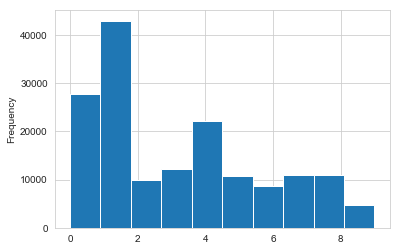

In [6]:
df_clusters.cluster_city.plot(kind='hist')

In [7]:
df_ord = df_ord.merge(df_clusters, on='order_id', how='left')
df_ord = df_ord.join(pd.get_dummies(df_ord['cluster_city'], prefix='cluster'))
df_ord = df_ord.join(pd.get_dummies(df_ord['service_class'], prefix='service'))

In [8]:
df_ord.head()

,order_id,customer_db_id,order_db_id,order_x,order_y,pickup_timeslot_from_datetime,pickup_timeslot_to_datetime,pickup_zip,order_state,order_created_datetime,...,cluster_6.0,cluster_7.0,cluster_8.0,cluster_9.0,service_Before Service Class,service_CLASSIC,service_EXPRESS,service_LITE,service_PERSIL,service_PLUS
0,DE-A-00034,56b8af2ad2cde8d32d0f0671,57c688d6d4cde8a02a40955c,52.527650,13.411222,2016-08-31 19:00:00,2016-08-31 21:00:00,10178,completed,2016-08-31 09:35:50,...,0,0,0,0,0,0,0,1,0,0
1,DE-A-00036,578724ecd3cde8ad719cc945,5ba4a69219207a41d47962df,52.539535,13.425363,2018-09-24 20:00:00,2018-09-24 21:00:00,10435,completed,2018-09-21 10:06:42,...,0,0,0,0,0,0,0,0,0,1
2,DE-A-00061,5a1ee6e144770903118b466f,5b69531a19207a30fd59e8af,52.491111,13.429692,2018-08-08 09:00:00,2018-08-08 10:00:00,12047,completed,2018-08-07 10:06:50,...,0,0,0,0,0,0,0,0,0,1
3,DE-A-00093,5a81b405447709dd6c8b4617,5a81b40a4677097f388b4576,52.488000,13.389250,2018-02-14 08:00:00,2018-02-14 09:00:00,10965,completed,2018-02-12 16:34:34,...,0,0,0,0,0,0,0,0,0,1
4,DE-A-00132,58d04f7246770953128b4740,5af0b68ec34362325828f24d,52.537420,13.399321,2018-05-09 06:00:00,2018-05-09 08:00:00,10115,completed,2018-05-07 22:26:54,...,0,1,0,0,0,0,0,1,0,0


# Create Dataset
- only completed orders
- customers with at least 1 completed order
- calculate frequencies between completed orders

In [9]:
# only completed orders
# df_comp = df_ord.loc[(df_ord.order_state == "completed") & (df_ord.completed_orders > 0)]
df_comp = df_ord.loc[(df_ord.completed_orders > 0)]
df_comp = df_comp.sort_values(['customer_db_id', 'order_created_datetime'])

# number completed orders
df_comp['order_comp_num'] = df_comp.groupby(['customer_db_id']).cumcount()

# days
df_comp['next_order_date'] = df_comp.groupby('customer_db_id')['order_created_datetime'].shift(-1)
df_comp['last_order_date'] = df_comp.groupby('customer_db_id')['order_created_datetime'].shift(1)
df_comp['days_until_next_comp'] = (df_comp.next_order_date - df_comp.order_created_datetime).dt.days
df_comp['days_since_last_comp'] = (df_comp.order_created_datetime - df_comp.last_order_date).dt.days
df_comp['weeks_until_next_comp'] = df_comp.days_until_next_comp // 7
df_comp['weeks_since_last_comp'] = df_comp.days_since_last_comp // 7
df_comp['2weeks_until_next_comp'] = df_comp.days_until_next_comp // 14
df_comp['2weeks_since_last_comp'] = df_comp.days_since_last_comp // 14

# frequency
df_comp['frequency_days_median'] = df_comp.groupby('customer_db_id')['days_since_last_comp'].transform(lambda x: x.expanding().median())
df_comp['frequency_weeks_median'] = df_comp.groupby('customer_db_id')['weeks_since_last_comp'].transform(lambda x: x.expanding().median())
df_comp['frequency_weeks_diff'] = df_comp.weeks_since_last_comp - df_comp.frequency_weeks_median
df_comp['frequency_weeks_avg'] = df_comp.groupby('customer_db_id')['weeks_since_last_comp'].transform(lambda x: x.expanding().mean())
df_comp['frequency_weeks_std'] = df_comp.groupby('customer_db_id')['weeks_since_last_comp'].transform(lambda x: x.expanding().std())

# revenue
df_comp['revenue_brutto'] = df_comp.revenue + df_comp.voucher_value
df_comp['last_order_revenue_brutto'] = df_comp.groupby('customer_db_id')['revenue_brutto'].shift(1)
df_comp['last_revenue_brutto_diff'] = df_comp.revenue_brutto - df_comp.last_order_revenue_brutto

# cluster
df_comp['last_order_cluster'] = df_comp.groupby(['customer_db_id'])['cluster_city'].shift(1)
df_comp['cluster_changed'] = (df_comp.cluster_city - df_comp.last_order_cluster != 0)

df_comp['gender'] = df_comp.gender.map({'male': -1, 'female': 1}).fillna(0)

df_comp = df_comp.drop(['next_order_date', 'last_order_date', 'last_order_revenue_brutto'], axis=1)

In [10]:
# frequencies per each cluster, calcualted based on all customers
cluster_frequencies = df_comp.groupby('cluster_city').agg({'days_until_next_comp': 'median',
                                                           'weeks_until_next_comp': 'median'}).reset_index()
cluster_frequencies = cluster_frequencies.rename(columns={'days_until_next_comp': 'cluster_median_freq_days',
                                                          'weeks_until_next_comp': 'cluster_median_freq_weeks'})
df_comp = df_comp.merge(cluster_frequencies, on='cluster_city', how='left')

In [11]:
df_comp.to_csv('../data/old/comp_orders.csv', index=False)

# Filter Data
- per city
- only active customers
- orders where the next completed order within 2 and 150 days
- orders where last completed order within 2 and 150 days
- revenue < 50
- exclude corporate
- exclude customers who had interaction with CC


# Dataset

In [12]:
num_completed_orders = 3

In [13]:
cust_ids_excl = df_comp.loc[(df_comp.city != 'London') |
                            (df_comp.days_until_next_comp > 90) | (df_comp.days_until_next_comp <= 2) |
                            (df_comp.days_since_last_comp > 90) | (df_comp.days_since_last_comp <= 2) |
                            (df_comp.revenue > 50) | (df_comp.corporate) | (df_comp.voucher_channel.str.contains('CC')) |
                            (df_comp.completed_orders < num_completed_orders)].customer_db_id.unique().tolist()
print(len(cust_ids_excl), '/', df_comp.customer_db_id.nunique())

29533 / 30185


In [14]:
df_city = df_comp.loc[~(df_comp.customer_db_id.isin(cust_ids_excl))]
df_city = df_city.loc[df_city.order_comp_num < num_completed_orders]

In [15]:
print('Num orders:', df_city.order_id.nunique())
print('Num customers:', df_city.customer_db_id.nunique())

Num orders: 1956
Num customers: 652


In [16]:
known_cust = df_city[df_city.completed_orders > num_completed_orders].customer_db_id.unique()
unknown_cust = df_city[df_city.completed_orders == num_completed_orders].customer_db_id.unique()

df_known = df_city.loc[df_city.customer_db_id.isin(known_cust)]
df_unknown = df_city.loc[df_city.customer_db_id.isin(unknown_cust)]

In [17]:
print('Known customers:', len(known_cust))
print('Unknown customers:', len(unknown_cust))

Known customers: 384
Unknown customers: 268


In [18]:
df_known['days_until_next_comp_bin_cat'] = pd.qcut(df_known.days_until_next_comp.sort_values(), 10)
df_known['days_until_next_comp_bin'] = pd.qcut(df_known.days_until_next_comp.sort_values(), 10, labels=False)

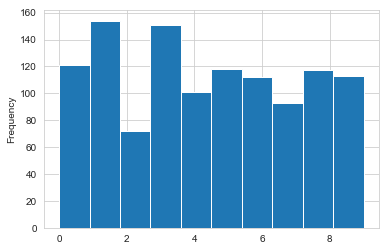

In [19]:
df_known.days_until_next_comp_bin.plot(kind='hist', bins=10)

In [20]:
cust_sample = random.sample(df_known.loc[df_known.completed_orders > 10].customer_db_id.unique().tolist(), 10)
cust_sample

['5988b13d447709c72c8b4627',
 '5990995b467709757d8b4606',
 '5888c2eb4677095c488b46b3',
 '5a1b0ddd447709b6388b464b',
 '59f205a8457709dc7c8b4660',
 '59a992e345770948198b458f',
 '593083cc447709cd488b45cc',
 '591f18c5467709ca478b4587',
 '5b41ae45c3436245fe5b67b0',
 '58bc643b447709b8608b46ba']

In [21]:
def plot_customer(customer_db_id):
    fig, ax= plt.subplots(figsize=(10,5))
    df_cust = df_comp.loc[df_comp.customer_db_id == customer_db_id]
    sns.lineplot(data=df_cust, x='order_num', y='days_until_next_comp', ax=ax)
    sns.lineplot(data=df_cust, x='order_num', y='cluster_city', ax=ax)

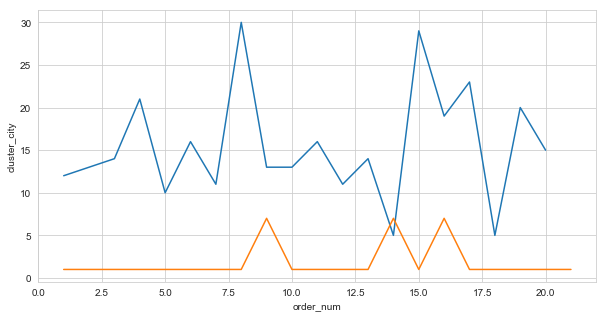

In [22]:
plot_customer(cust_sample[5])

In [23]:
cust_sample[5]

'59a992e345770948198b458f'

# Select Features
into customer features, prior features and last order features

In [24]:
df_known_feats = df_known.set_index(['customer_db_id', 'order_comp_num']).unstack().swaplevel(axis=1)

feats = ['revenue_brutto', 'weeks_since_last_comp', 'frequency_weeks_median', 'frequency_weeks_diff', 'frequency_weeks_std',
        'quantity', 'order_created_month', 'days_since_last_comp', 'frequency_days_median', 'voucher_used']
feats_cluster = [i for i in df_known.columns if 'cluster_' in i]
feats_cluster.remove('cluster_city')
feats_cluster.remove('cluster_name')
feats_cluster.remove('cluster_median_freq_days')
pred_name = 'days_until_next_comp_bin'

In [25]:
df_known_last = df_known_feats[num_completed_orders-1][feats + feats_cluster + ['gender', pred_name]].reset_index()
df_known_last.head()

,customer_db_id,revenue_brutto,weeks_since_last_comp,frequency_weeks_median,frequency_weeks_diff,frequency_weeks_std,quantity,order_created_month,days_since_last_comp,frequency_days_median,...,cluster_4.0,cluster_5.0,cluster_6.0,cluster_7.0,cluster_8.0,cluster_9.0,cluster_changed,cluster_median_freq_weeks,gender,days_until_next_comp_bin
0,5811cf91d2cde8195c3e8c49,24.260445,4.0,4.5,-0.5,0.707107,10.0,4,30.0,35.0,...,0,0,0,0,0,0,True,2.0,-1.0,8
1,586a563244770900208b464d,17.048702,3.0,3.0,0.0,0.000000,1.0,2,23.0,22.0,...,0,0,0,0,0,0,False,2.0,1.0,7
2,586cb22c467709ea3a8b45b2,26.169012,1.0,1.0,0.0,0.000000,8.0,1,9.0,10.5,...,0,0,0,1,0,0,False,3.0,-1.0,2
3,586e039a447709fe488b456c,34.916421,3.0,7.0,-4.0,5.656854,5.0,4,27.0,52.0,...,0,0,1,0,0,0,True,2.0,-1.0,5
4,586e43ee44770903498b46a0,14.450804,0.0,0.5,-0.5,0.707107,1.0,1,6.0,6.5,...,0,0,0,0,0,0,False,2.0,1.0,1


In [26]:
df_known_prior = df_known_feats[list(range(num_completed_orders-1))]
df_known_prior = df_known_prior.swaplevel(axis=1)
df_known_prior = df_known_prior[feats + [pred_name]].fillna(-1)

# df_known_prior = pd.DataFrame(df_known_prior.to_records())
df_known_prior.head()

revenue_brutto            weeks_since_last_comp  \
order_comp_num                        0          1                     0   
customer_db_id                                                             
5811cf91d2cde8195c3e8c49      44.626072  24.754080                  -1.0   
586a563244770900208b464d      14.642013  14.662247                  -1.0   
586cb22c467709ea3a8b45b2      38.937993  34.030318                  -1.0   
586e039a447709fe488b456c      -1.000000  47.114414                  -1.0   
586e43ee44770903498b46a0      38.763138  14.159094                  -1.0   

                               frequency_weeks_median        \
order_comp_num               1                      0     1   
customer_db_id                                                
5811cf91d2cde8195c3e8c49   5.0                   -1.0   5.0   
586a563244770900208b464d   3.0                   -1.0   3.0   
586cb22c467709ea3a8b45b2   1.0                   -1.0   1.0   
586e039a447709fe488b456c  11.0                   -1.0  11.0   
586e43ee44770903498b46a0   1.0                   -1.0   1.0   

                         frequency_weeks_diff      frequency_weeks_std       \
order_comp_num                              0    1                   0    1   
customer_db_id                                                                
5811cf91d2cde8195c3e8c49                 -1.0  0.0                -1.0 -1.0   
586a563244770900208b464d                 -1.0  0.0                -1.0 -1.0   
586cb22c467709ea3a8b45b2                 -1.0  0.0                -1.0 -1.0   
586e039a447709fe488b456c                 -1.0  0.0                -1.0 -1.0   
586e43ee44770903498b46a0                 -1.0  0.0                -1.0 -1.0   

                         ... order_created_month    days_since_last_comp  \
order_comp_num           ...                   0  1                    0   
customer_db_id           ...                                               
5811cf91d2cde8195c3e8c49 ...                   2  3                 -1.0   
586a563244770900208b464d ...                   1  1                 -1.0   
586cb22c467709ea3a8b45b2 ...                   1  1                 -1.0   
586e039a447709fe488b456c ...                   1  3                 -1.0   
586e43ee44770903498b46a0 ...                   1  1                 -1.0   

                               frequency_days_median       voucher_used  \
order_comp_num               1                     0     1            0   
customer_db_id                                                            
5811cf91d2cde8195c3e8c49  40.0                  -1.0  40.0         True   
586a563244770900208b464d  21.0                  -1.0  21.0        False   
586cb22c467709ea3a8b45b2  12.0                  -1.0  12.0         True   
586e039a447709fe488b456c  77.0                  -1.0  77.0        False   
586e43ee44770903498b46a0   7.0                  -1.0   7.0        False   

                                days_until_next_comp_bin     
order_comp_num                1                        0  1  
customer_db_id                                               
5811cf91d2cde8195c3e8c49  False                        8  7  
586a563244770900208b464d  False                        5  6  
586cb22c467709ea3a8b45b2  False                        3  1  
586e039a447709fe488b456c  False                        9  6  
586e43ee44770903498b46a0  False                        1  0  

[5 rows x 22 columns]

In [27]:
df_known_m = df_known_prior.merge(df_known_last, on='customer_db_id', how='left').set_index(['customer_db_id'])
df_known_m.head()

,"(revenue_brutto, 0)","(revenue_brutto, 1)","(weeks_since_last_comp, 0)","(weeks_since_last_comp, 1)","(frequency_weeks_median, 0)","(frequency_weeks_median, 1)","(frequency_weeks_diff, 0)","(frequency_weeks_diff, 1)","(frequency_weeks_std, 0)","(frequency_weeks_std, 1)",...,cluster_4.0,cluster_5.0,cluster_6.0,cluster_7.0,cluster_8.0,cluster_9.0,cluster_changed,cluster_median_freq_weeks,gender,days_until_next_comp_bin
customer_db_id,,,,,,,,,,,,,,,,,,,,,
5811cf91d2cde8195c3e8c49,44.626072,24.754080,-1.0,5.0,-1.0,5.0,-1.0,0.0,-1.0,-1.0,...,0,0,0,0,0,0,True,2.0,-1.0,8
586a563244770900208b464d,14.642013,14.662247,-1.0,3.0,-1.0,3.0,-1.0,0.0,-1.0,-1.0,...,0,0,0,0,0,0,False,2.0,1.0,7
586cb22c467709ea3a8b45b2,38.937993,34.030318,-1.0,1.0,-1.0,1.0,-1.0,0.0,-1.0,-1.0,...,0,0,0,1,0,0,False,3.0,-1.0,2
586e039a447709fe488b456c,-1.000000,47.114414,-1.0,11.0,-1.0,11.0,-1.0,0.0,-1.0,-1.0,...,0,0,1,0,0,0,True,2.0,-1.0,5
586e43ee44770903498b46a0,38.763138,14.159094,-1.0,1.0,-1.0,1.0,-1.0,0.0,-1.0,-1.0,...,0,0,0,0,0,0,False,2.0,1.0,1


In [28]:
df_known_m = df_known_m.dropna()

# Baseline

In [29]:
def print_class_metrics(pred_y, true_y):
    print('Accuracy: {}%'.format(metrics.accuracy_score(pred_y, true_y).round(5) * 100))
    print('F1 score: ', metrics.f1_score(pred_y, true_y, average='weighted').round(5))

def print_reg_metrics(pred_y, true_y):
    print('MSE: ', metrics.mean_squared_error(pred_y, true_y).round(5))
    print('R2 score:', metrics.r2_score(pred_y, true_y).round(5))

def print_proba_metric(pred_y, true_y):
    print('Log Loss:', metrics.log_loss(pred_y, true_y))

In [30]:
# df_known_last['predicted_days_until_next_comp'] = df_known_last.frequency_exp_median
# df_known_last['predicted_weeks_until_next_comp'] = df_known_last.predicted_days_until_next_comp // 7

# y_pred = df_known_last.predicted_weeks_until_next_comp.values.reshape(-1, 1)
# y_true = df_known_last.weeks_until_next_comp.values.reshape(-1, 1)

# print_class_metrics(y_pred, y_true)

# Predictions

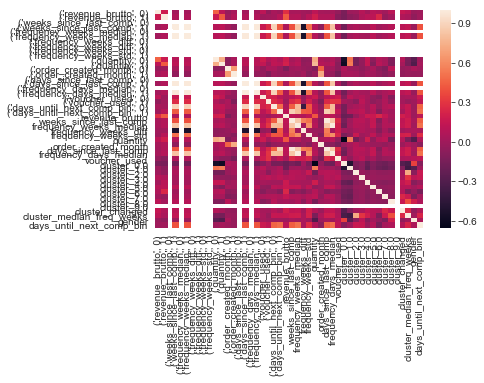

In [31]:
sns.heatmap(df_known_m.corr(), xticklabels=df_known_m.columns, yticklabels=df_known_m.columns)

In [32]:
X = df_known_m.drop(pred_name, axis=1).values
y = df_known_m[pred_name].values
n_classes = df_known_m[pred_name].nunique()
print(X.shape, y.shape)

(375, 45) (375,)


In [33]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
X = sel.fit_transform(X)

In [34]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
y_norm = y.reshape(-1,1)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.25, random_state=42, stratify=y_norm)

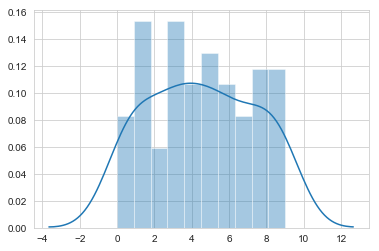

In [36]:
sns.distplot(y_test, bins=10)

In [37]:
log_reg = linear_model.LogisticRegression().fit(X_train, y_train)
print('train', log_reg.score(X_train, y_train), 'test', log_reg.score(X_test, y_test)) 
acc = metrics.accuracy_score(y_train, log_reg.predict(X_train).reshape(-1,1))
print('{}%'.format(round(acc * 100, 3)))
acc = metrics.accuracy_score(y_test, log_reg.predict(X_test).reshape(-1,1))
print('{}%'.format(round(acc * 100, 3)))

train 0.327402135231 test 0.255319148936
32.74%
25.532%


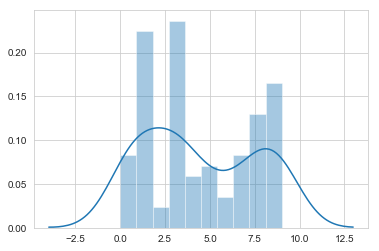

In [38]:
sns.distplot(log_reg.predict(X_test), bins=10)

Text(34,0.5,'True')

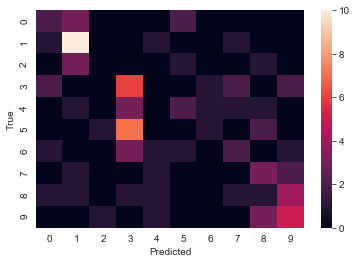

In [39]:
sns.heatmap(metrics.confusion_matrix(y_test, log_reg.predict(X_test).reshape(-1,1)))
plt.xlabel('Predicted')
plt.ylabel('True')

In [40]:
lin_reg = linear_model.LinearRegression().fit(X_train, y_train)
print('train', lin_reg.score(X_train, y_train), 'test', lin_reg.score(X_test, y_test)) 

train 0.353092744687 test 0.386861458217


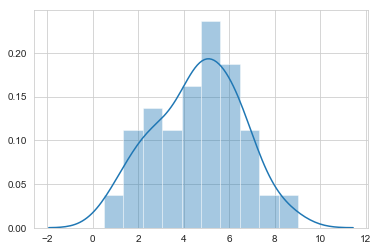

In [41]:
sns.distplot(lin_reg.predict(X_test), bins=10)

Text(34,0.5,'True')

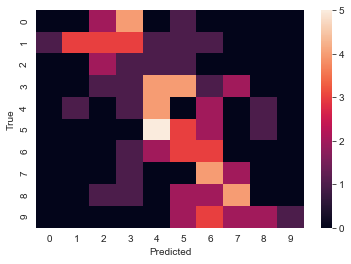

In [42]:
sns.heatmap(metrics.confusion_matrix(y_test, lin_reg.predict(X_test).round()))
plt.xlabel('Predicted')
plt.ylabel('True')

In [43]:
sup = svm.SVC(class_weight='balanced', verbose=True, gamma='auto').fit(X_train, y_train)
print('train', sup.score(X_train, y_train), 'test', sup.score(X_test, y_test)) 
acc = metrics.accuracy_score(y_test, sup.predict(X_test).reshape(-1,1))
print('{}%'.format(round(acc * 100, 3)))

[LibSVM]train 0.533807829181 test 0.255319148936
25.532%


In [44]:
neigh = KNeighborsClassifier(n_neighbors=40).fit(X_train, y_train) 
neigh.score(X_test, y_test)
print('train', neigh.score(X_train, y_train), 'test', neigh.score(X_test, y_test))
acc = metrics.f1_score(y_test, neigh.predict(X_test), average='weighted')
print('{}%'.format(round(acc * 100, 3)))

train 0.23487544484 test 0.223404255319
17.539%


In [45]:
frst = RandomForestClassifier(n_estimators=200, max_depth=4).fit(X_train, y_train)
print('train', frst.score(X_train, y_train), 'test', frst.score(X_test, y_test))
acc = metrics.accuracy_score(y_test, frst.predict(X_test))
print('{}%'.format(round(acc * 100, 3)))

train 0.604982206406 test 0.276595744681
27.66%


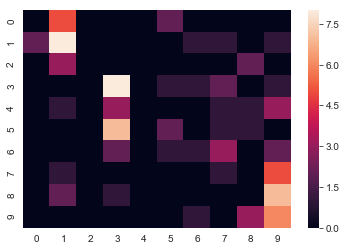

In [46]:
sns.heatmap(metrics.confusion_matrix(y_test, frst.predict(X_test).reshape(-1,1)))

In [47]:
mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10, 10), random_state=1, max_iter=2000, 
                    learning_rate_init=0.001, verbose=True, batch_size=1, alpha=0.9).fit(X_train, y_train)
print('train', mlp.score(X_train, y_train), 'test', mlp.score(X_test, y_test))
mlp.fit(X_train, y_train)
mlp.score(X_test, y_test)
acc = metrics.accuracy_score(y_test, mlp.predict(X_test))
print('{}%'.format(round(acc * 100, 3)))

train 0.804270462633 test 0.170212765957
17.021%


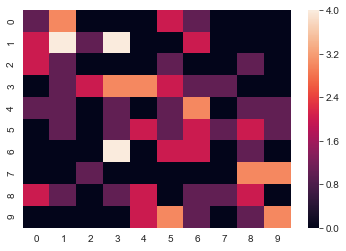

In [48]:
sns.heatmap(metrics.confusion_matrix(y_test, mlp.predict(X_test).reshape(-1,1)))

In [49]:
import xgboost as xgb

In [70]:
param = {'max_depth': 10, 'eta': 0.1, 'silent': 0, 'objective': 'multi:softmax'}
param['nthread'] = 4
param['eval_metric'] = 'mlogloss'
param['num_class'] = 10
param['gamma'] = 5

In [71]:
dtrain = xgb.DMatrix(X_train, label=y_train.squeeze())
dtest = xgb.DMatrix(X_test, label=y_test.squeeze())

In [72]:
evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [73]:
num_round = 100
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-mlogloss:2.2801	train-mlogloss:2.2383
[1]	eval-mlogloss:2.26055	train-mlogloss:2.19469
[2]	eval-mlogloss:2.24476	train-mlogloss:2.17212
[3]	eval-mlogloss:2.22999	train-mlogloss:2.15692
[4]	eval-mlogloss:2.21707	train-mlogloss:2.13601
[5]	eval-mlogloss:2.20897	train-mlogloss:2.12552
[6]	eval-mlogloss:2.1998	train-mlogloss:2.11601
[7]	eval-mlogloss:2.19334	train-mlogloss:2.10738
[8]	eval-mlogloss:2.18486	train-mlogloss:2.09954
[9]	eval-mlogloss:2.17982	train-mlogloss:2.08711
[10]	eval-mlogloss:2.17606	train-mlogloss:2.08209
[11]	eval-mlogloss:2.17013	train-mlogloss:2.07221
[12]	eval-mlogloss:2.1673	train-mlogloss:2.06956
[13]	eval-mlogloss:2.16635	train-mlogloss:2.0688
[14]	eval-mlogloss:2.16549	train-mlogloss:2.06811
[15]	eval-mlogloss:2.16471	train-mlogloss:2.06749
[16]	eval-mlogloss:2.164	train-mlogloss:2.06694
[17]	eval-mlogloss:2.16335	train-mlogloss:2.06644
[18]	eval-mlogloss:2.16276	train-mlogloss:2.06599
[19]	eval-mlogloss:2.16222	train-mlogloss:2.06559
[20]	eval-mloglos

[164]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[165]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[166]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[167]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[168]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[169]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[170]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[171]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[172]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[173]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[174]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[175]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[176]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[177]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[178]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[179]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[180]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[181]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[182]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[183]	eval-mlogloss:2.1475	train-mlogloss:2.05154


[328]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[329]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[330]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[331]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[332]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[333]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[334]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[335]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[336]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[337]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[338]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[339]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[340]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[341]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[342]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[343]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[344]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[345]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[346]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[347]	eval-mlogloss:2.1475	train-mlogloss:2.05154


[492]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[493]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[494]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[495]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[496]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[497]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[498]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[499]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[500]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[501]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[502]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[503]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[504]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[505]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[506]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[507]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[508]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[509]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[510]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[511]	eval-mlogloss:2.1475	train-mlogloss:2.05154


[656]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[657]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[658]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[659]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[660]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[661]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[662]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[663]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[664]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[665]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[666]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[667]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[668]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[669]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[670]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[671]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[672]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[673]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[674]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[675]	eval-mlogloss:2.1475	train-mlogloss:2.05154


[820]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[821]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[822]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[823]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[824]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[825]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[826]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[827]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[828]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[829]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[830]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[831]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[832]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[833]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[834]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[835]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[836]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[837]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[838]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[839]	eval-mlogloss:2.1475	train-mlogloss:2.05154


[984]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[985]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[986]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[987]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[988]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[989]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[990]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[991]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[992]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[993]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[994]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[995]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[996]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[997]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[998]	eval-mlogloss:2.1475	train-mlogloss:2.05154
[999]	eval-mlogloss:2.1475	train-mlogloss:2.05154


In [65]:
bst.eval(dtest)

'[0]\teval-mlogloss:2.217055'

In [55]:
metrics.accuracy_score(bst.predict(xgb.DMatrix(X_test)), y_test)

0.28723404255319152